1. Import Libraries & Load Data

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    r2_score, mean_squared_error, accuracy_score, f1_score, roc_auc_score, 
    precision_recall_curve, auc, roc_curve
)

# Ensure 'Data' directory exists
plot_dir = "../Plots/"
os.makedirs(plot_dir, exist_ok=True)

# Load dataset
df = pd.read_csv("../Data/heart_disease_uci.csv") 

# Display first few rows & dataset info
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB


(   age     sex    dataset               cp  trestbps   chol    fbs  \
 0   63    Male  Cleveland   typical angina     145.0  233.0   True   
 1   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
 2   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
 3   37    Male  Cleveland      non-anginal     130.0  250.0  False   
 4   41  Female  Cleveland  atypical angina     130.0  204.0  False   
 
           restecg  thalch  exang  oldpeak        slope   ca  \
 0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
 1  lv hypertrophy   108.0   True      1.5         flat  3.0   
 2  lv hypertrophy   129.0   True      2.6         flat  2.0   
 3          normal   187.0  False      3.5  downsloping  0.0   
 4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   
 
                 thal  num  
 0       fixed defect    0  
 1             normal    2  
 2  reversable defect    1  
 3             normal    0  
 4             normal    0  ,
 None)

 2. Data Preprocessing

In [2]:
# %% Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Drop columns with excessive missing values (>50% missing)
drop_cols = ["ca", "thal", "slope"]
df.drop(columns=drop_cols, inplace=True)
print(f"Dropped columns: {drop_cols}")

# Impute missing values (Median for numeric, Mode for categorical)
num_impute_cols = ["trestbps", "chol", "thalch", "oldpeak"]
cat_impute_cols = ["fbs", "restecg", "exang"]

for col in num_impute_cols:
    df[col].fillna(df[col].median(), inplace=True)
for col in cat_impute_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing Values After Handling:\n", df.isnull().sum())

# Encode categorical variables using One-Hot Encoding
df = pd.get_dummies(df, columns=["dataset", "sex", "cp", "restecg", "exang"], drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ["age", "trestbps", "chol", "thalch", "oldpeak"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("✅ Data Preprocessing Completed!")


Missing Values:
 age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64
Dropped columns: ['ca', 'thal', 'slope']

Missing Values After Handling:
 age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64
✅ Data Preprocessing Completed!


C:\Users\HP\AppData\Local\Temp\ipykernel_11444\3555690413.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_11444\3555690413.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

 3. Define Features & Targets

In [3]:
# %% Define Features (X) and Targets (y)
# num columnhas multiple classification [0,1,2,3,4] we want to have Binary classification for our analysis
df["num"] = df["num"].apply(lambda x: 1 if x > 0 else 0)  #Binary classification: 1 = Disease, 0 = No Disease

X = df.drop(columns=["chol", "num"])  # Drop target variable
y_reg = df["chol"]  # Target for regression
y_clf = df["num"]   # Target for classification

# Train-test split (80-20)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Standardize numerical features
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)
X_train_clf = scaler.fit_transform(X_train_clf)
X_test_clf = scaler.transform(X_test_clf)

print("✅ Data Split and Standardized!")


✅ Data Split and Standardized!


4. Train Regression Model (ElasticNet)

📊 Best ElasticNet Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
✅ Regression Performance → R²: 0.5337, RMSE: 0.6814


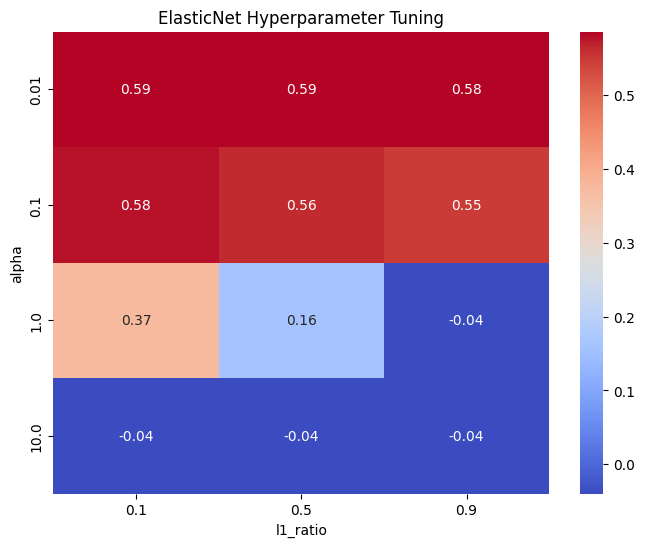

In [4]:
# %% Define Function to Plot Hyperparameter Tuning Heatmap
def plot_heatmap(grid_search, param1, param2):
    results = pd.DataFrame(grid_search.cv_results_)
    pivot_table = results.pivot(index=f'param_{param1}', columns=f'param_{param2}', values='mean_test_score')
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', cbar=True)
    plt.title("ElasticNet Hyperparameter Tuning")
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.show()

# Define Hyperparameter Grid
param_grid = {
    "alpha": [0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.5, 0.9]
}

# Train ElasticNet with GridSearchCV
elastic_net = GridSearchCV(ElasticNet(), param_grid, scoring="r2", cv=5)
elastic_net.fit(X_train_reg, y_train_reg)

# Predict and Evaluate
y_pred_reg = elastic_net.best_estimator_.predict(X_test_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

print(f"📊 Best ElasticNet Parameters: {elastic_net.best_params_}")
print(f"✅ Regression Performance → R²: {r2:.4f}, RMSE: {rmse:.4f}")

# Plot Hyperparameter Tuning Heatmap
plot_heatmap(elastic_net, "alpha", "l1_ratio")


5. Train Classification Models (Logistic Regression & k-NN)

In [5]:
# %% Train & Evaluate Logistic Regression and k-NN
log_reg = GridSearchCV(LogisticRegression(), {"penalty": ["l2"], "solver": ["lbfgs"]}, scoring="roc_auc", cv=5)
knn = GridSearchCV(KNeighborsClassifier(), {"n_neighbors": [5, 10]}, scoring="roc_auc", cv=5)

log_reg.fit(X_train_clf, y_train_clf)
knn.fit(X_train_clf, y_train_clf)

# Get probability scores
y_prob_lr = log_reg.best_estimator_.predict_proba(X_test_clf)[:, 1]
y_prob_knn = knn.best_estimator_.predict_proba(X_test_clf)[:, 1]

# Compute AUROC & AUPRC
roc_lr = roc_auc_score(y_test_clf, y_prob_lr)
roc_knn = roc_auc_score(y_test_clf, y_prob_knn)

precision_lr, recall_lr, _ = precision_recall_curve(y_test_clf, y_prob_lr)
pr_auc_lr = auc(recall_lr, precision_lr)

precision_knn, recall_knn, _ = precision_recall_curve(y_test_clf, y_prob_knn)
pr_auc_knn = auc(recall_knn, precision_knn)

print(f"📊 Logistic Regression - AUROC: {roc_lr:.4f}, AUPRC: {pr_auc_lr:.4f}")
print(f"📊 k-NN Classifier - AUROC: {roc_knn:.4f}, AUPRC: {pr_auc_knn:.4f}")


📊 Logistic Regression - AUROC: 0.8993, AUPRC: 0.9183
📊 k-NN Classifier - AUROC: 0.9228, AUPRC: 0.9396


 6. Generate AUROC & AUPRC Plots

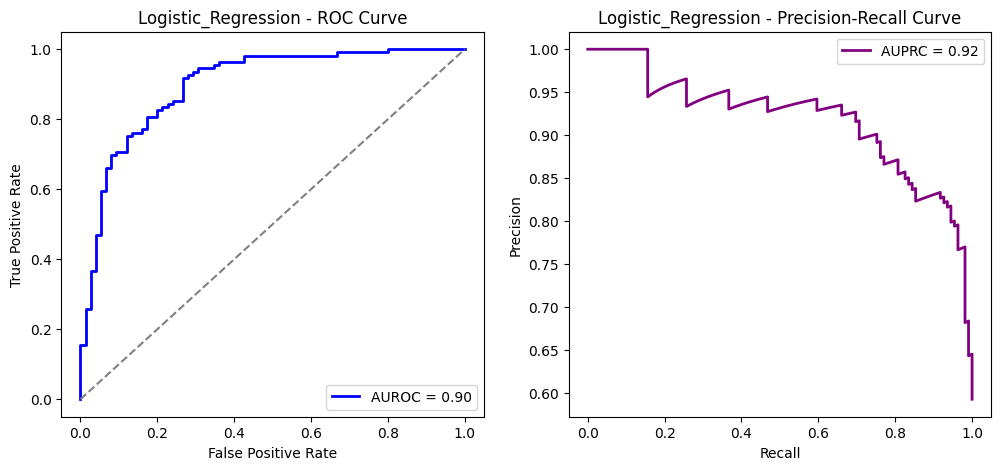

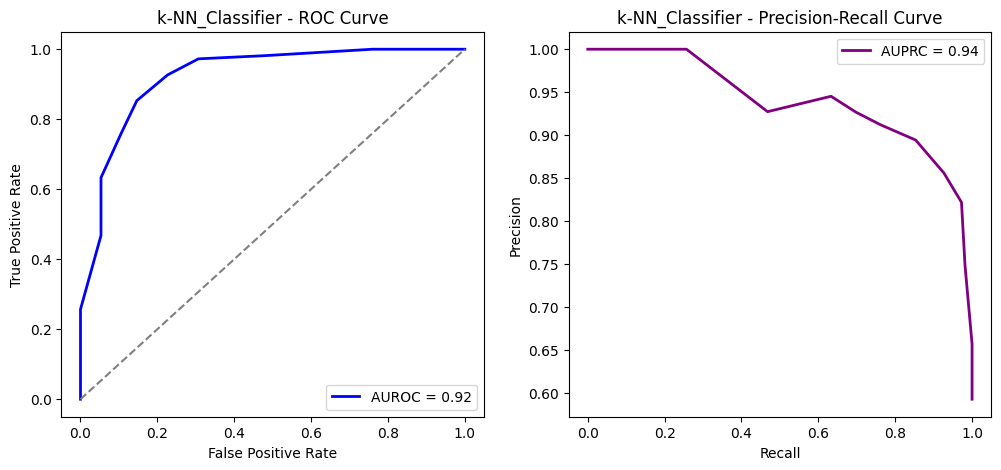

In [6]:
# %% Function to Plot AUROC & Precision-Recall Curves
def plot_auroc_pr(y_true, y_prob, model_name):
    roc_auc = roc_auc_score(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # AUROC Plot
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    ax1.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.2f}')
    ax1.plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title(f"{model_name} - ROC Curve")
    ax1.legend()

    # Precision-Recall Curve
    ax2.plot(recall, precision, color='purple', lw=2, label=f'AUPRC = {pr_auc:.2f}')
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title(f"{model_name} - Precision-Recall Curve")
    ax2.legend()

    plt.savefig(os.path.join(plot_dir, f"{model_name}_AUROC.png"))
    plt.savefig(os.path.join(plot_dir, f"{model_name}_Precision_Recall_Curve.png"))
    plt.show()

# Generate Plots
plot_auroc_pr(y_test_clf, y_prob_lr, "Logistic_Regression")
plot_auroc_pr(y_test_clf, y_prob_knn, "k-NN_Classifier")
